## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AirBnB.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
df.price = np.log1p(df.price.values)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [7]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [10]:
from sklearn.feature_extraction import DictVectorizer

In [11]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [27]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names = dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [1.66]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [1.81]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)**2))

In [36]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [40]:
y_pred = rf.predict(X_val)
rmse(y_pred, y_val)

0.08133789289779414

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

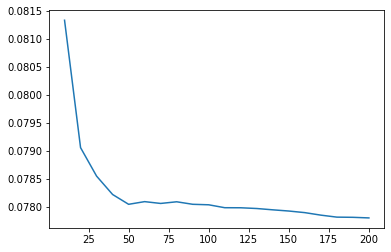

In [44]:
scores = []
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    error = rmse(y_val, y_pred)
    
    scores.append((n, error))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'error'])
plt.plot(df_scores.n_estimators, df_scores.error)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [82]:
scores = []
from tqdm import tqdm

In [83]:
for d in tqdm([10, 15, 20, 25]):
    for n in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        error = rmse(y_val, y_pred)
    
        scores.append((n, d, error))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'error'])

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [12:54<00:00, 193.53s/it]


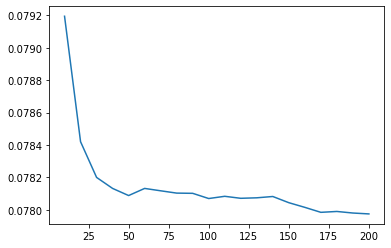

In [52]:
plt.plot(df_scores.n_estimators, df_scores.error, label='max_depth = %s' % 10)


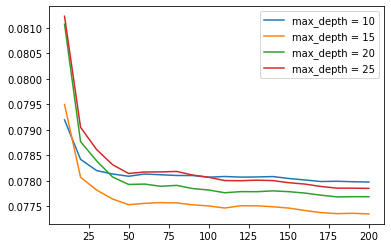

In [84]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.error, label='max_depth = %s' % d)
plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [61]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([7.51200966e-02, 3.26981588e-02, 1.44606718e-01, 1.47783414e-01,
       4.98369830e-02, 7.96504797e-04, 1.35045012e-03, 3.84380718e-02,
       6.57590412e-04, 7.75827628e-05, 4.01687647e-02, 5.95746244e-02,
       3.96990240e-01, 6.79573450e-03, 5.10506683e-03])

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

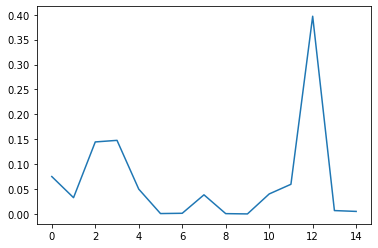

In [64]:
plt.plot(rf.feature_importances_)
dv.get_feature_names()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [65]:
import xgboost as xgb

In [66]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [67]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [75]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [70]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

Now change `eta` first to `0.1` and then to `0.01`

In [71]:
scores = {}

In [76]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

(0.0, 0.1)

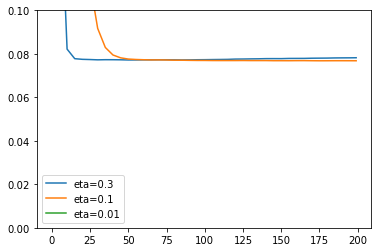

In [78]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()
plt.ylim(0, .1)

What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

